<a href="https://colab.research.google.com/github/shambakey1/gen_text_to_image_human_body_images/blob/main/experimenting_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from diffusers import StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPTokenizer, CLIPTextModel
import torch,json

In [ ]:
def load_measurements(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # Clean "_tbr" suffixes and invalid entries
    measurements = {k: v.replace('_tbr', '') if isinstance(v, str) else v
                    for k, v in data.items()}
    return measurements

def create_prompt(measurements, view="front"):
    # Extract key measurements
    arm_length = measurements.get("arm_length_cm")
    leg_length = measurements.get("leg_length_cm")
    height = measurements.get("height")
    weight = measurements.get("weight")
    chest = measurements.get("chest_circumference_cm")
    waist = measurements.get("waist_circumference_cm")
    shoulders = measurements.get("shoulder_width_cm")
    front_build = measurements.get("front_build_cm")
    hip = measurements.get("hips_circumference_cm")
    neck = measurements.get("neck_circumference_cm")
    neck_waist = measurements.get("neck_waist_length_front_cm")
    pelvis = measurements.get("pelvis_circumference_cm")
    thigh = measurements.get("thigh_circumference_cm")
    under_chest = measurements.get("under_chest_circumference_cm")
    age = measurements.get("age")
    gender = measurements.get("gender")
    race = measurements.get("race")
    profession = measurements.get("profession")

    prompt = (
    f"Technical {view} outline of {gender}, "
    f"Height:{height}, Chest:{chest}, Waist:{waist}, Shoulders:{shoulders}, Leg:{leg_length}, "
    f"Arm:{arm_length}, Hip:{hip}, Neck:{neck}, Pelvis:{pelvis}, "
    f"Thigh:{thigh}, Under-Chest:{under_chest}, Weight:{weight}kg, "
    f"Age:{age}, Profession:{profession}, Race:{race}, "
    f"Front-Build:{front_build}, Neck-Waist:{neck_waist}, "
    f"Line drawing, no face/genitals, white background, "
    f"anatomical markers, vector template, "
    f"minimal shading, measurement diagram"
    )

    prompt1 = (
        f"Technical flat sketch of a male human body {view} view, body outline only, "
        f"height {height} cm, chest {chest} cm, waist {waist} cm, shoulders {shoulders} cm, legs {leg_length} cm. "
        f"Minimalist line drawing, monochrome, plain white background, no facial features, no genitalia, "
        f"neutral pose, anatomical diagram style, body measurement markers, clear body contours, "
        f"professional tailoring template, vector illustration, no shading, no colors."
    )

    print(prompt)

    return prompt

def create_prompt_embeddings(prompt):
  # Load the CLIP Tokenizer and Text Encoder
  # These are the components responsible for converting text into numerical embeddings
  # that the diffusion model's U-Net understands.
  text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
  tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
  # Move text_encoder to GPU if available
  if torch.cuda.is_available():
    text_encoder.to("cuda")
    print("Text encoder moved to CUDA (GPU).")
  else:
    print("CUDA (GPU) not available for text encoder, using CPU.")

  # Tokenize the prompt and create input IDs
  # The `max_length` here is crucial. For Stable Diffusion v1.5, the text encoder
  # typically processes inputs in chunks of 77 tokens (including start/end tokens).
  # `truncation=True` will cut off the prompt if it exceeds this length.
  # However, the tokenizer often handles longer prompts by internally padding/truncating
  # or by returning multiple segments if the model supports it.
  # The pipeline handles the concatenation of embeddings from these segments automatically
  # when you pass a long string.
  # Here, we are manually demonstrating how the embeddings are formed.

  # For standard SD 1.x models, the max_length for the text encoder is 77 tokens.
  # The tokenizer's model_max_length is typically 77.
  # When a prompt is longer than 77 tokens, the tokenizer internally pads it or
  # breaks it into chunks. The `diffusers` pipeline then stitches the embeddings
  # together. This manual process clarifies that.
  tokens = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length, # Often 77 for CLIP
    truncation=True, # Truncates if longer than max_length
    return_tensors="pt"
  )
  #tokenizer(
  #    prompt,
  #    truncation=True,
  #    max_length=77,  # CLIP's limit
  #    return_length=True
  #)

  # Move inputs to GPU if the text encoder is on GPU
  if torch.cuda.is_available():
    tokens = {k: v.to("cuda") for k, v in tokens.items()}

  # Check the actual tokenized length
  print(f"Tokenized prompt length: {tokens['input_ids'].shape[1]} tokens (max {tokenizer.model_max_length})")

  # Generate the prompt embeddings
  with torch.no_grad():
    prompt_embeds = text_encoder(tokens["input_ids"]).last_hidden_state
  print(f"Shape of generated prompt embeddings: {prompt_embeds.shape}")
  #print(len(tokenizer(prompt).input_ids))
  #return tokens
  #return tokenizer.decode(tokens['input_ids'])
  return prompt_embeds

def generate_image(prompt_embeds, output_path="gen_image.png"):

    # Validate token length first
    #print("Tokens length")
    #print("*******************")
    #truncated_prompt=validate_prompt_length(prompt)  # Add this line

    #pipe = StableDiffusionPipeline.from_pretrained(
    #    "runwayml/stable-diffusion-v1-5",
    #    torch_dtype=torch.float16,
    #    safety_checker=None
    #).to("cuda" if torch.cuda.is_available() else "cpu")

  # Load the Stable Diffusion pipeline without the default text encoder
  # Since we're providing the prompt embeddings directly, we don't need the pipeline
  # to handle text encoding.
  model_id = "runwayml/stable-diffusion-v1-5"
  pipeline = StableDiffusionPipeline.from_pretrained(model_id, text_encoder=None).to("cuda" if torch.cuda.is_available() else "cpu") # Set text_encoder to None

  negative_prompt = "nudity, face, hands, fingers, clothing, shadows, realism, 3D, photo"

  # Generate the image using the pre-computed prompt embeddings
  print("Generating image using pre-computed embeddings...")
  generated_image = pipeline(
    prompt_embeds=prompt_embeds,
    num_inference_steps=50,
    guidance_scale=9.0
  ).images[0]

  # Save the image
  generated_image.save(output_path)
  print(f"Image '{image_filename}' has been generated successfully!")

In [ ]:
# prompt: load the uploaded json file using the previous load_measurements function

# Assuming the uploaded JSON file is named 'measurements.json'
json_path = 'measurements.json'
measurements = load_measurements(json_path)

# Generate front view image
prompts=create_prompt(measurementsm,'front')
embeds=create_prompt_embeddings(prompts)
generate_image(embeds,'front_view_image.png')

# Generate side view image
prompts=create_prompt(measurements,'side')
embeds=create_prompt_embeddings(prompts)
generate_image(embeds,'side_view_image.png')

{'arm_length_cm': '65.0',
 'chest_circumference_cm': '93.0',
 'front_build_cm': '41.0',
 'hips_circumference_cm': '86.0',
 'leg_length_cm': '108.0',
 'neck_circumference_cm': '37.0',
 'neck_waist_length_front_cm': '49.0',
 'pelvis_circumference_cm': '92.0',
 'shoulder_width_cm': '42.0',
 'thigh_circumference_cm': '49.0',
 'under_chest_circumference_cm': '84.0',
 'waist_circumference_cm': '84.0',
 'height': '172.0',
 'weight': '70.0',
 'age': '42',
 'gender': 'male',
 'race': 'black',
 'profession': 'Intermediate_prof'}

In [ ]:
tokens=validate_prompt_length(create_prompt(measurements))
tokens

Technical front outline of male, Height:172.0, Chest:93.0, Waist:84.0, Shoulders:42.0, Leg:108.0, Arm:65.0, Hip:86.0, Neck:37.0, Pelvis:92.0, Thigh:49.0, Under-Chest:84.0, Weight:70.0kg, Age:42, Profession:Intermediate_prof, Race:black, Front-Build:41.0, Neck-Waist:49.0, Line drawing, no face/genitals, white background, anatomical markers, vector template, minimal shading, measurement diagram
Text encoder moved to CUDA (GPU).
Tokenized prompt length: 77 tokens (max 77)
Shape of generated prompt embeddings: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.9488, -0.8150,  2.3584,  ..., -0.3743,  0.0116,  0.0103],
         [ 0.9083,  0.6686,  0.1576,  ..., -1.2901,  0.1431,  0.6561],
         ...,
         [-1.1510, -0.3655,  1.1586,  ..., -1.1722, -1.2429,  0.1306],
         [ 0.3143, -0.6482,  0.0084,  ..., -0.6527, -0.2240,  0.6361],
         [-0.2266, -0.5534,  0.1764,  ..., -0.7546,  1.0475, -0.0538]]],
       device='cuda:0')

In [ ]:
# Generate front view
front_prompt = create_prompt(measurements, view="front")
embed_prompt=validate_prompt_length(front_prompt)
generate_image(front_prompt, "generated_front.png")


Technical front outline of male, Height:172.0, Chest:93.0, Waist:84.0, Shoulders:42.0, Leg:108.0, Arm:65.0, Hip:86.0, Neck:37.0, Pelvis:92.0, Thigh:49.0, Under-Chest:84.0, Weight:70.0kg, Age:42, Profession:Intermediate_prof, Race:black, Front-Build:41.0, Neck-Waist:49.0, Line drawing, no face/genitals, white background, anatomical markers, vector template, minimal shading, measurement diagram
Text encoder moved to CUDA (GPU).
Tokenized prompt length: 77 tokens (max 77)
Shape of generated prompt embeddings: torch.Size([1, 77, 768])


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Generating image using pre-computed embeddings...


AttributeError: 'str' object has no attribute 'shape'

In [ ]:
# Generate side view
side_prompt = create_prompt(measurements, view="right side")
generate_image(side_prompt, "generated_side.png")

Tokens length
*******************


Token indices sequence length is longer than the specified maximum sequence length for this model (114 > 77). Running this sequence through the model will result in indexing errors


114


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (114 > 77). Running this sequence through the model will result in indexing errors


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
model_id = "stable-diffusion-v1-5/stable-diffusion-v1-5"

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16,use_safetensors=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
pipeline = pipeline.to("cuda")

In [ ]:
prompt = 'well detailed, high quality picture of a well dressed male (from head to toe) following the following dimension (feel free to scale the image as suits you):\n\
	"arm_length_cm": "65.0_tbr", \n\
	"chest_circumference_cm": "93.0", \n\
	"front_build_cm": "41.0_tbr", \n\
	"hips_circumference_cm": "86.0", \n\
	"leg_length_cm": "108.0", \n\
	"neck_circumference_cm": "37.0", \n\
	"neck_waist_length_front_cm": "49.0", \n\
	"pelvis_circumference_cm": "92.0", \n\
	"shoulder_width_cm": "42.0", \n\
	"thigh_circumference_cm": "49.0", \n\
	"under_chest_circumference_cm": "84.0", \n\
	"waist_circumference_cm": "84.0", \n\
	"height": "172.0", \n\
	"weight": "70.0", \n\
	"age": "42", \n\
	"gender": "male", \n\
	"race": "black", \n\
	"profession": "Intermediate_prof"\n\
'

In [ ]:
generator = torch.Generator("cuda").manual_seed(0)

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['", " hips _ circumference _ cm ": " 8 6 . 0 ", " leg _ length _ cm ": " 1 0 8 . 0 ", " neck _ circumference _ cm ": " 3 7 . 0 ", " neck _ waist _ length _ front _ cm ": " 4 9 . 0 ", " pelvis _ circumference _ cm ": " 9 2 . 0 ", " shoulder _ width _ cm ": " 4 2 . 0 ", " thigh _ circumference _ cm ": " 4 9 . 0 ", " under _ chest _ circumference _ cm ": " 8 4 . 0 ", " waist _ circumference _ cm ": " 8 4 . 0 ", " height ": " 1 7 2 . 0 ", " weight ": " 7 0 . 0 ", " age ": " 4 2 ", " gender ": " male ", " race ": " black ", " profession ": " intermediate _ prof "']


  0%|          | 0/50 [00:00<?, ?it/s]

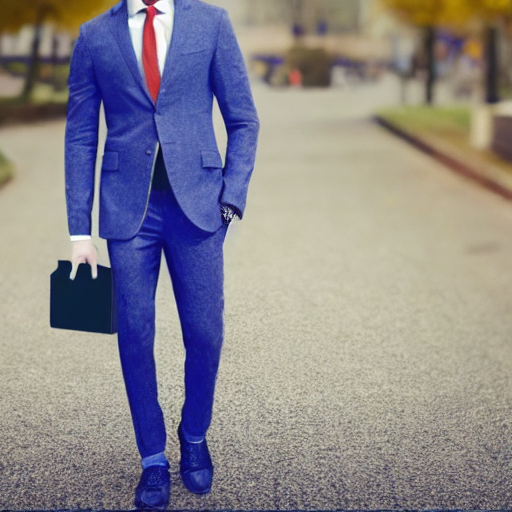

In [ ]:
image = pipeline(prompt, generator=generator).images[0]
image

In [ ]:

from diffusers import StableDiffusionPipeline

def load_measurements(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    # Clean "_tbr" suffixes and invalid entries
    measurements = {k: v.replace('_tbr', '') if isinstance(v, str) else v
                    for k, v in data.items()}
    return measurements

def create_prompt(measurements, view="front"):
    # Extract key measurements
    height = measurements.get("height", "172")
    weight = measurements.get("weight", "70")
    chest = measurements.get("chest_circumference_cm", "93")
    waist = measurements.get("waist_circumference_cm", "84")
    shoulders = measurements.get("shoulder_width_cm", "42")

    prompt = (
        f"A {measurements.get('gender', 'male')}, {height} cm tall, {weight} kg, {measurements.get('race', 'black')} race, "
        f"with chest circumference {chest} cm, waist {waist} cm, and shoulders {shoulders} cm. "
        f"Full-body {view} view, realistic proportions, anatomical accuracy, plain background."
    )
    return prompt

def generate_image(prompt, output_path):
    # Load Stable Diffusion pipeline (use a GPU if available)
    pipe = StableDiffusionPipeline.from_pretrained(
        "runwayml/stable-diffusion-v1-5",
        torch_dtype=torch.float16,
        safety_checker=None
    ).to("cuda" if torch.cuda.is_available() else "cpu")

    # Generate image
    image = pipe(prompt, num_inference_steps=50).images[0]
    image.save(output_path)

if __name__ == "__main__":
    measurements = load_measurements("measurements.json")

    # Generate front view
    front_prompt = create_prompt(measurements, view="front")
    generate_image(front_prompt, "generated_front.png")

    # Generate side view
    side_prompt = create_prompt(measurements, view="side")
    generate_image(side_prompt, "generated_side.png")